# Modelado de Tópicos en las reseñas de Amazon

Material de apoyo:
[Basic tasks with spacy](https://necronet.github.io/Spacy-getting-started-in-spanish/)

[Topic Modeling on Spanish Texts](https://medium.com/@armandj.olivares/topic-modeling-on-spanish-text-f7a5e998fb90) 

### Usar amazon reviews y replicar la últimas práctica de Topic Modeling

In [24]:
import pandas as pd
import numpy as np
import pickle
import gensim
import re
from gensim.corpora import Dictionary
import nltk
from nltk.corpus import wordnet as wn 
import spacy
from sklearn.feature_extraction.text import CountVectorizer


In [11]:
train_data = pd.read_json('../data/amazon-reviews-ml/dataset_es_train.json', lines=True)
test_data = pd.read_json('../data/amazon-reviews-ml/dataset_es_test.json', lines=True)

In [16]:
all_data = pd.concat(objs=[train_data, test_data], keys=[])


In [42]:
sample = all_data.sample(n=5000)

### Cleaning the raw text and obtaining a corpus
For Topic Clustering we must do some preprocessing to the text before we can feed it to an LDA model.
A common approach is to use only the nouns, dismissing the verbs, adjectives and adverbs.
Sometimes bigrams are used (e.g. 'No aprendemos', 'en línea', 'bien planeado'), but since we are only using nouns we might want to explore keywords first.

1. Lemmatize the words
2. Use bigrams **
3. Using POS tagging to subselect only nouns
4. Clean the remaining text from punctuation, etc.

In [45]:
# remove stopwords from every review
STOPWORDS_ES = set(nltk.corpus.stopwords.words("spanish"))

In [37]:
# For tokenization, tagging, lemmatization, stemming and NER
nlp = spacy.load("es_core_news_md")

In [46]:
def normalize_tokenize_lemmatize(text):
    doc = nlp(text)
    VALID_POS = {'PROPN', 'NOUN'}
    # Avoid empty word in beggining with doc[1:]
    return [word.lemma_ for word in doc if word.lemma_ not in stopwords 
                                            and word.pos_ in VALID_POS]

In [47]:
# Takes a few seconds
all_data['text'] = all_data['review'].apply(normalize_tokenize_lemmatize)
# 19:39
# 20:29

In [48]:
all_data['text']

0       [television, Nevir, ka, pantalla, mes, respues...
1       [Dinero, basura, compra, Horrible, inglés, inf...
2                         [unidad, unidad, forma, estafa]
3       [PRODUCTO, recibido, vendedor, mes, espera, pr...
4                                   [Devuelto, co, talla]
                              ...                        
4995    [función, sobra, color, envío, plazo, incidencia]
4996                    [vendedor, material, descripción]
4997                                            [medalla]
4998      [timbre, bici, xiaomi, modelo, timbre, manilla]
4999    [auricular, cable, verdad, tipo, casco, inalam...
Name: text, Length: 205000, dtype: object

#### Transform the text into a bag of words corpus for the model

In [49]:
dictionary = Dictionary(all_data['text'].to_list())

In [50]:
# Assign ids to every word without gaps
dictionary.compactify()

# Filter out words that appear in less than 2 documents, thos appearing in more than 97% of corpus, and keep all other words
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)

# Reassign ids to every word without gaps after filtering
dictionary.compactify()   

In [51]:
corpus = [dictionary.doc2bow(text) for text in all_data['text']]

### Feeding the corpus to the LDA Model
1. HDP: We could infer the number of topics in the corpus with an HDP model, but is not always easy to interpret
2. LSI: this model tells us the optimal number of topics by looking at a coherence measurement.
3. Once we have a good estimate for number of topics we can do LDA model
https://medium.com/@armandj.olivares/topic-modeling-on-spanish-text-f7a5e998fb90

#### 1. HDP Model to obtain a possible number of topics

More info: [Hierarchical Dirichlet Process](https://radimrehurek.com/gensim/models/hdpmodel.html)

In [1]:
from gensim.models import HdpModel
# Gives us a inference of the number of possible Topics in the data.
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary, random_state= 0)

hdpmodel.print_topics(num_words=10)
# All of the 20 models have word overlaps, so they are useless

NameError: name 'corpus' is not defined

#### 2.LDA Model to find the optimal number of topics
- We try a number of topics from 1 to 20 and looks for the best coherence measurement

In [56]:
texts = all_data['text'].to_list()

In [57]:
# Find the optimal number of topics based on coherence
from gensim.models import LdaModel
from gensim.models import CoherenceModel

MAX_TOPICS = 20
c_v = []
lm_list = []

for n_topics in range(1, MAX_TOPICS+1):
    lm = LdaModel(corpus=corpus, num_topics = n_topics, id2word=dictionary)

    lm_list.append(lm)
    
    cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
    c_v.append(cm.get_coherence())
    
    # 21:42

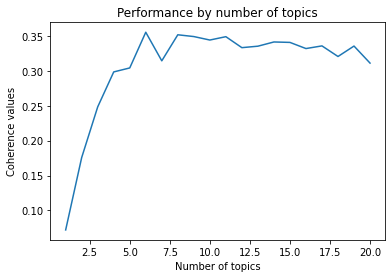

In [58]:
import matplotlib.pyplot as plt

plt.plot(range(1, MAX_TOPICS+1), c_v)
plt.title('Performance by number of topics')
plt.xlabel('Number of topics')
plt.ylabel('Coherence values')
plt.show()

From the results we can see that **6** topics is probably the best model (coherence value `0.35522555294632824`)

In [61]:
model_6topics = lm_list[5]
model_6topics.print_topics()

[(0,
  '0.128*"producto" + 0.029*"tiempo" + 0.027*"compra" + 0.027*"envío" + 0.025*"regalo" + 0.023*"día" + 0.022*"entrega" + 0.022*"vendedor" + 0.020*"problema" + 0.013*"Amazon"'),
 (1,
  '0.026*"luz" + 0.025*"año" + 0.020*"uso" + 0.018*"color" + 0.018*"batería" + 0.018*"sonido" + 0.016*"hora" + 0.016*"Genial" + 0.015*"compra" + 0.014*"día"'),
 (2,
  '0.168*"calidad" + 0.124*"precio" + 0.025*"relación" + 0.022*"compra" + 0.021*"material" + 0.021*"producto" + 0.011*"Calidad" + 0.011*"color" + 0.010*"imagen" + 0.009*"función"'),
 (3,
  '0.062*"Perfecto" + 0.029*"cable" + 0.024*"tiempo" + 0.017*"Perfecta" + 0.017*"Excelente" + 0.013*"descripción" + 0.011*"Ideal" + 0.011*"problema" + 0.010*"uso" + 0.009*"cometido"'),
 (4,
  '0.038*"funda" + 0.031*"tamaño" + 0.030*"pantalla" + 0.029*"libro" + 0.027*"móvil" + 0.020*"función" + 0.015*"teléfono" + 0.015*"protector" + 0.015*"cámara" + 0.014*"reloj"'),
 (5,
  '0.042*"foto" + 0.031*"tal" + 0.021*"caja" + 0.020*"agua" + 0.016*"tamaño" + 0.015*"ju

#### Interpretación de los seis tópicos
Al usar monogramas probablemente sea más difícil para un humano encontrar la relación entre las palabras asociadas a un topic.

Un mejor análisis sería trabajar por separado los reviews positivos y los reviews negativos y correr de nuevo el topic modeling. Esto muy seguramente nos daría temas muy distintos para cada una de las categorías.

En este caso, tratando todas las reseñas por igual, podemos dar una interpretación más o menos tersa:
1. Acerca del tiempo de entrega o envío
2. Acerca de los componentes o versión del producto
3. Acerca de la calidad del producto
4. Manifestación del cliente de su gusto con el producto
5. Acerca de teléfonos celulares y sus características
6. ????

Posibles mejoras:
- Uso de bigramas o trigramas
- Modelos separados de reseñas positivas y negativas
